# Simple text classification using ```scikit-learn```

## Import packages


In [2]:
# system tools
import os
import sys
sys.path.append(os.path.join("..", "..", "CDS-LANG"))

# data munging tools
import pandas as pd
import utils.classifier_utils as clf

# Machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# handle warnings
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Reading in the data

In [7]:
filename = os.path.join("..", "..", "CDS-LANG", "tabular_examples", "fake_or_real_news.csv")

data = pd.read_csv(filename, index_col=0)

__Inspect data__

In [8]:
data.sample(10)

,title,text,label
8270,Hillary Clinton v Donald Trump in 2016,"With just four days left until election day, m...",FAKE
6001,Republican Mark Kirk Just Lost His Race Agains...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
6014,Hillary Clinton has a deep commitment.,(7 fans) - Advertisement - \nHillary Clinton i...,FAKE
6232,Public Support for the Euro,"by Yves Smith \nBy Felix Roth, Associated Rese...",FAKE
5566,Here Is Why the Trump Administration Will Be a...,Originally appeared at The American Conservati...,FAKE
1082,Is the GOP's stop Trump campaign too late?,Washington (CNN) The Republican Party is wakin...,REAL
2648,The GOP case against Loretta Lynch falls apart,Loretta Lynch had them at Jim Crow.\n\nSenate ...,REAL
9116,"TRUTH: No Apartheid in Israel, Says Black Sout...","TRUTH: No Apartheid in Israel, Says Black Sout...",FAKE
4913,"Trump Campaign Bombs in Virginia, Again",Empty bleachers and a hostile student body gre...,REAL
2667,Think Facebook isn't political? Think again | ...,There’s a conceit that says everything at Face...,REAL


In [9]:
data.shape

(6335, 3)

<br>
Q: How many examples of each label do we have?

In [10]:
data["label"].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

## Create balanced data

We can use the function ```balance``` to create a more even dataset.

In [11]:
data_balanced = clf.balance(data, 1000)

In [12]:
data_balanced.shape

(2000, 3)

<br>

What do the label counts look like now?

In [13]:
data_balanced["label"].value_counts()

FAKE    1000
REAL    1000
Name: label, dtype: int64

<br>

Let's now create new variables called ```X``` and ```y```, taking the data out of the dataframe so that we can mess around with them.

In [14]:
X = data_balanced["text"]
y = data_balanced["label"]

# Train-test split

I've included most of the 'hard work' for you here already, because these are long cells which might be easy to mess up while live-coding.

Instead, we'll discuss what's happening. If you have questions, don't be shy!

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,           # texts for the model
                                                    y,          # classification labels
                                                    test_size=0.2,   # create an 80/20 split
                                                    random_state=42) # random state for reproducibility

# Vectorizing and Feature Extraction

Vectorization. What is it and why are all the cool kids talking about it?

Essentially, vectorization is the process whereby textual or visual data is 'transformed' into some kind of numerical representation. One of the easiest ways to do this is to simple count how often individual features appear in a document.

Take the following text: 
<br><br>
<i>My father’s family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip. So, I called myself Pip, and came to be called Pip.</i>
<br>

We can convert this into the following vector

| and | be | being | both | called | came | christian | could | explicit | family | father | i | infant | longer | make | more | my | myself | name | names | nothing | of | or | philip | pip | pirrip | s | so | than | to | tongue|
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |  --- |
| 2 | 1 | 1 | 1 | 2 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 3 | 1 | 2 | 1 | 1 | 1 | 1 | 1 | 3 | 1 | 1 | 1 | 1 | 1 | 1 |

<br>
Our textual data is hence reduced to a jumbled-up 'vector' of numbers, known somewhat quaintly as a <i>bag-of-words</i>.
<br>
<br>
To do this in practice, we first need to create a vectorizer. 

Tfidf vectors tend to be better for training classifiers. Why might that be?

__Create vectorizer object__

In [31]:
vectorizer = TfidfVectorizer(ngram_range = (1,2),     # unigrams and bigrams (1 word and 2 word units)
                             lowercase =  True,       # why use lowercase?
                             max_df = 0.95,           # remove very common words
                             min_df = 0.05,           # remove very rare words
                             max_features = 100)      # keep only top 500 features

This vectorizer is then used to turn all of our documents into a vector of numbers, instead of text.

In [32]:
# first we fit to the training data...
X_train_feats = vectorizer.fit_transform(X_train)

#... then do it for our test data
X_test_feats = vectorizer.transform(X_test)

# get feature names
feature_names = vectorizer.get_feature_names()

## Classifying and predicting

We now have to 'fit' the classifier to our data. This means that the classifier takes our data and finds correlations between features and labels.

These correlations are then the *model* that the classifier learns about our data. This model can then be used to predict the label for new, unseen data.

In [33]:
classifier = LogisticRegression(random_state=42).fit(X_train_feats, y_train)

Q: How do we use the classifier to make predictions?

In [34]:
y_pred = classifier.predict(X_test_feats)

Q: What are the predictions for the first 20 examples of the test data?

In [35]:
print(y_pred[:20])

['REAL' 'FAKE' 'REAL' 'FAKE' 'REAL' 'REAL' 'FAKE' 'REAL' 'FAKE' 'REAL'
 'REAL' 'REAL' 'REAL' 'FAKE' 'FAKE' 'FAKE' 'FAKE' 'REAL' 'FAKE' 'REAL']


We can also inspect the model, in order to see which features are most informative when trying to predict a label. 

To do this, we can use the ```show_features``` function that I defined earlier - how convenient!

Q: What are the most informative features? Use ```show_features```to find out!

In [36]:
clf.show_features(vectorizer, y_train, classifier, n=20)

FAKE				REAL

-2.4601	by             		3.6021	republican     
-2.3895	us             		3.3344	but            
-1.6117	this           		2.5730	state          
-1.5798	you            		2.5214	he             
-1.3774	is             		2.4609	obama          
-1.2638	be             		2.3682	on the         
-1.0669	just           		2.0494	that           
-0.8685	to the         		2.0206	party          
-0.8637	been           		1.9572	his            
-0.8334	so             		1.6895	in             
-0.8211	with           		1.6591	president      
-0.8187	into           		1.6571	more           
-0.7344	like           		1.5620	campaign       
-0.7231	when           		1.5169	than           
-0.6338	our            		1.3886	could          
-0.6285	now            		1.2767	do             
-0.6214	no             		1.2037	those          
-0.6166	of             		1.1697	about          
-0.5915	if             		1.1593	who            


## Evaluate

We can also do some quick calculations, in order to assess just how well our model performs.

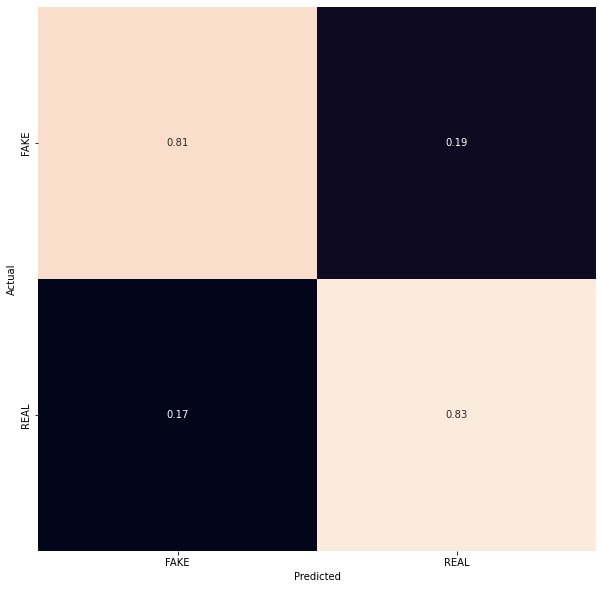

In [37]:
clf.plot_cm(y_test, y_pred, normalized=True)

In [38]:
classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

              precision    recall  f1-score   support

        FAKE       0.83      0.81      0.82       199
        REAL       0.81      0.83      0.82       201

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



## Cross validation and further evaluation

One thing we can't be sure of is that our model performance is simply related to how the train-test split is made.

To try to mitigate this, we can perform cross-validation, in order to test a number of different train-test splits and finding the average scores.

Let's do this on the full dataset

In [39]:
X_vect = vectorizer.fit_transform(X)

The first plot is probably the most interesting. Some terminology:

- If two curves are "close to each other" and both of them but have a low score, the model suffers from an underfitting problem (High Bias)

- If there are large gaps between two curves, then the model suffer from an overfitting problem (High Variance)


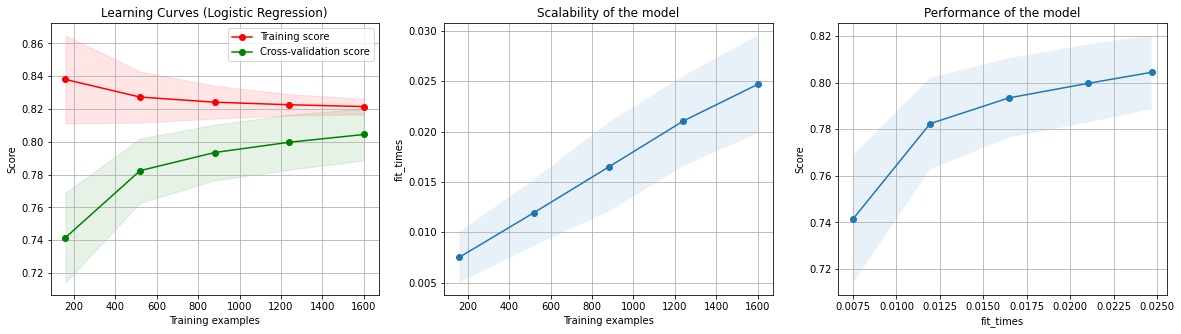

In [40]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression(random_state=42)
clf.plot_learning_curve(estimator, title, X_vect, y, cv=cv, n_jobs=4)

- The second plot shows the times required by the models to train with various sizes of training dataset. 
- The third plot show how much time was required to train the models for each training sizes.

## Save models

In [41]:
from joblib import dump, load
dump(classifier, "LR_classifier.joblib")

['LR_classifier.joblib']

In [42]:
loaded_clf = load("LR_classifier.joblib")

In [44]:
sentence = "Hilary Clinton is a crook who eats babies!"

In [47]:
test_sentence = vectorizer.transform([sentence])
loaded_clf.predict(test_sentence)

array(['FAKE'], dtype=object)

## Simple Neural Network with ```scikit-learn```

In [49]:
mlp = MLPClassifier(random_state = 42,
                   hidden_layer_sizes = (32,),
                   activation = "logistic",
                   max_iter = 500
                  )

In [50]:
mlp.fit(X_train_feats, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(32,), max_iter=500,
              random_state=42)

In [51]:
y_pred = mlp.predict(X_test_feats)

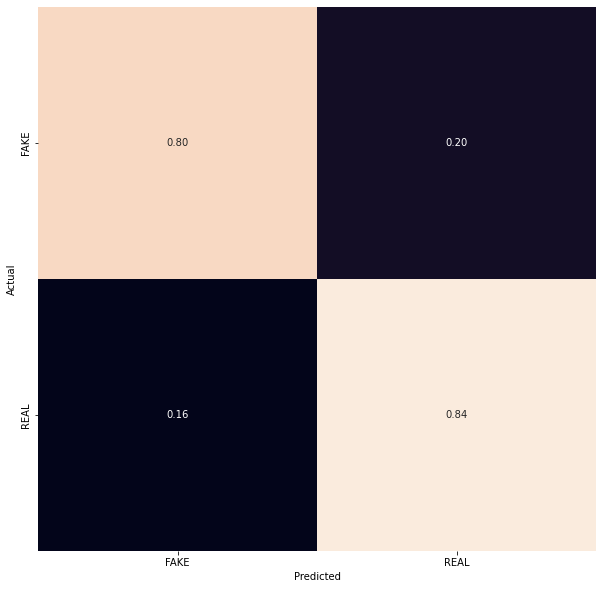

In [52]:
clf.plot_cm(y_test, y_pred, normalized=True)

In [53]:
classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

              precision    recall  f1-score   support

        FAKE       0.83      0.80      0.82       199
        REAL       0.81      0.84      0.82       201

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



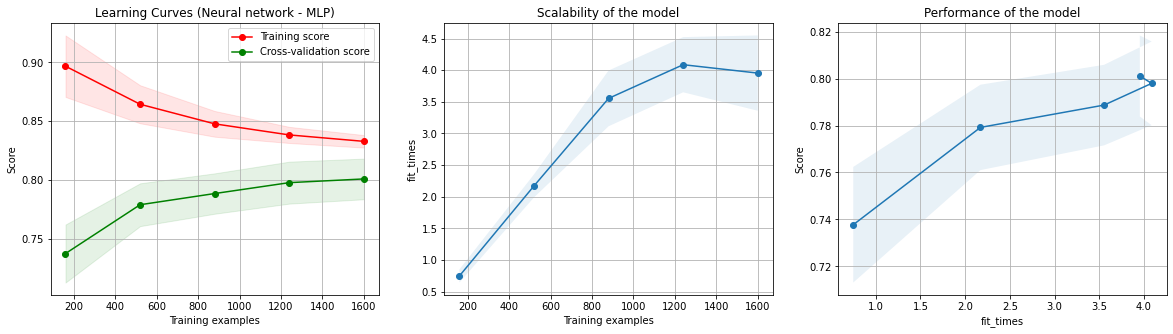

In [54]:
title = "Learning Curves (Neural network - MLP)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

clf.plot_learning_curve(mlp, title, X_vect, y, cv=cv, n_jobs=30)